# VE DG and DeepMoD testing loop

In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import torch

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen
import deepymod_torch.VE_params as VE_params
from deepymod_torch.DeepMod import run_deepmod
from deepymod_torch.library_functions import mech_library

np_seed = 2
torch_seed = 0

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

Here, we set many parameters that define our problem. We define:
- The model and model type (which is determined by input_type)
- The shape, frequency and magnitude of the sinc input manipulation
- The sampling rate from the data that will be generated

I also here define any other parameters that need to be defined (for saving or the normal flow) but are not being used or tested for this particular use of the notebook.

In [2]:
investigated_param = 'Scanning for 2nd order viable GKM models strain input - C_1 33 uF'

input_type = 'Strain'
# if input_type == 'Strain':
#     model = 'GMM'
# elif input_type == 'Stress':
#     model = 'GKM'
mech_model = 'GKM'

E = [5e-4, 5e-4, 5e-4]
eta = [33e-6, 1e-3]

In [3]:
func_desc = 'sigmoid sinc'
omega = 2*np.pi # As I programmed 5 osc, with an f_AWG of 1 Hz, this makes f_prog 5 Hz.
# This leaves omega as 10pi (2pi * f_AWG * f_prog)
# I choose to aim for omega pi, so if f_AWG set to 0.1 Hz, this is accomplished.
Amp = 7
input_expr_1 = lambda t: Amp*np.sin(omega*t)/(omega*t)
input_torch_lambda_1 = lambda t: Amp*torch.sin(omega*t)/(omega*t)

def sigmoid_expr(max_value=1, h_shift=1, width=1):
    return lambda t: max_value / (1 + h_shift*np.exp(-t/width))
def sigmoid_torch_expr(max_value=1, h_shift=1, width=1):
    return lambda t: max_value / (1 + h_shift*torch.exp(-t/width))
width_val = 0.1
shift_val = 1/(300*width_val)
input_expr_2 = sigmoid_expr(h_shift=shift_val, width=width_val)
input_torch_lambda_2 = sigmoid_torch_expr(h_shift=shift_val, width=width_val)

# Multiplying 2 signals together
input_expr = lambda t: input_expr_1(t) * input_expr_2(t)
input_torch_lambda = lambda t: input_torch_lambda_1(t) * input_torch_lambda_2(t)

number_of_samples = 1000
noise_level = 0

To generate data, we need to choose where and when to evaluate the target data for a given manipulation. Below, we choose those time points.

In [4]:
time_array = np.linspace(-5*np.pi/omega, 10*np.pi/omega, 5000).reshape(-1, 1)

In [5]:
scaled_omega = 1.2
time_sf = omega/scaled_omega
scaled_time_array = time_array*time_sf

Next we configure DeepMoD. We configure:
- The initial L1 regularisation penalty
- The learning rate
- The number of epochs at each stage of training
- The size and shape of the network
- The library function for calculating potential terms relevant to VE problems.

In [6]:
percent = 0.05
thresh_pc = lambda *args: percent

In [7]:
library_config = {'library_func': mech_library,
                  'diff_order': 2,
                  'coeff_sign': 'positive',
                  'input_type': input_type}
network_config = {'hidden_dim': 30}
optim_config = {'lr_coeffs': 0.002,
                'thresh_func': thresh_pc,
                'PINN': True}
report_config = {'plot': True}

Information for saving that doesn't change each loop....

In [8]:
parent_folder = '../data/Results'
first_subfolder = investigated_param.replace('.', '-')

Here we define the values we wish to test.

In this use of the notebook it is the value of the PyTorch random seed. The purpose is to investigate if DeepMoD is sensitive to this, does it discover different models given different starting initialisations. Aferwards will want to check if each model replicates essentially the same curves.

In [9]:
# 2nd viscosities
param_vals_1 = np.geomspace(1.99526231e-6, 1e-3, num=10)
param_vals_1

array([1.99526231e-06, 3.98107170e-06, 7.94328233e-06, 1.58489319e-05,
       3.16227766e-05, 6.30957344e-05, 1.25892541e-04, 2.51188643e-04,
       5.01187233e-04, 1.00000000e-03])

Next we run the loop. In each iteration of the loop:

- Parameter(s) of interest will be updated.
- Data will be synthesised from the model and manipulation description.
- The data will be prepared for DeepMoD injection
- DeepMoD will try its best
- The results will be organised and saved in a named folder.
- The progress will be available in Tensorboard files also which will need to be manually dragged across after the loop is done (or during!)

The total number of tests are now (relevant only when looping 2 or more sets of values):

In [10]:
# len(tau_2_values)*len(noise_level_values)*number_of_seeds

Main loop!

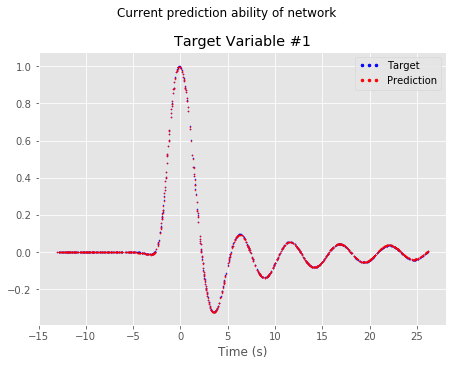

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |     Sign |
     100000    100.00%               0s   2.09e-06   1.85e-06   2.40e-07   0.00e+00   0.00e+00 
[Parameter containing:
tensor([[0.0979],
        [0.2714],
        [0.1406],
        [0.9534],
        [0.1097]], requires_grad=True)]
Saving results


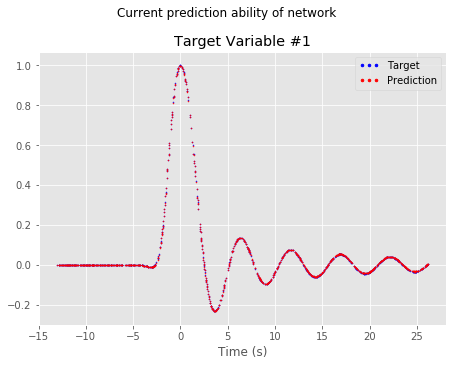

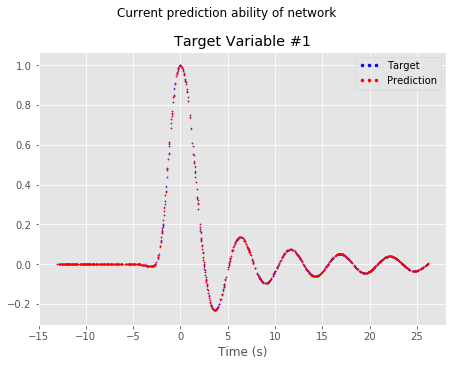

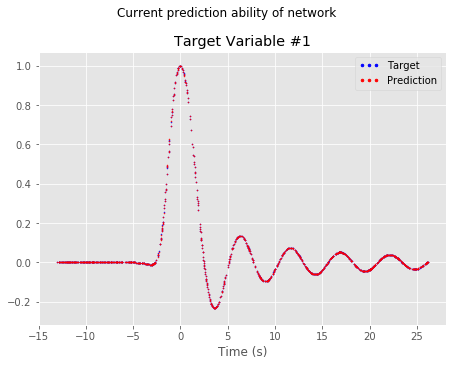

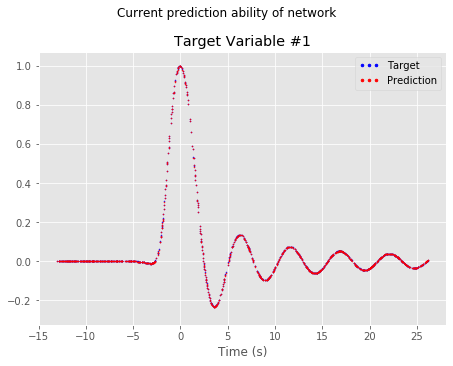

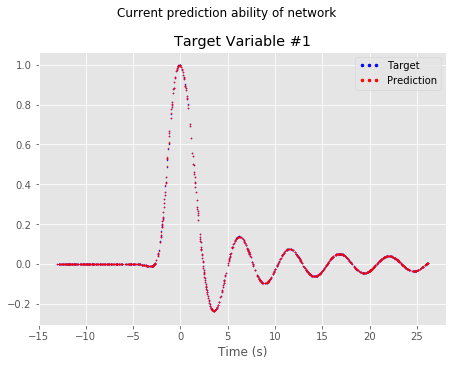

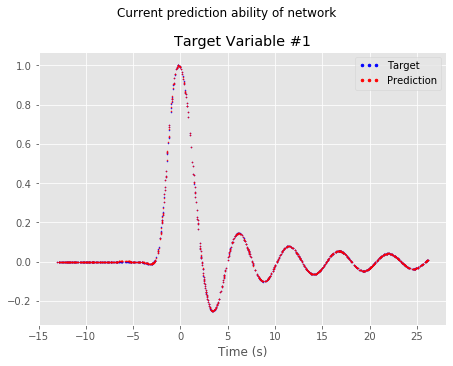

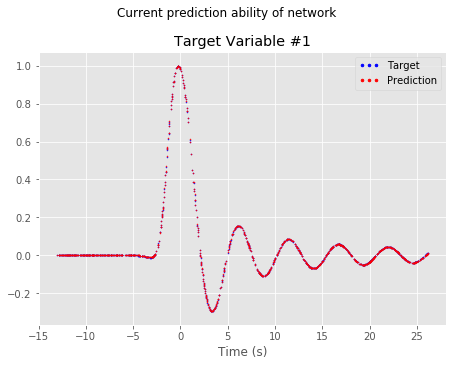

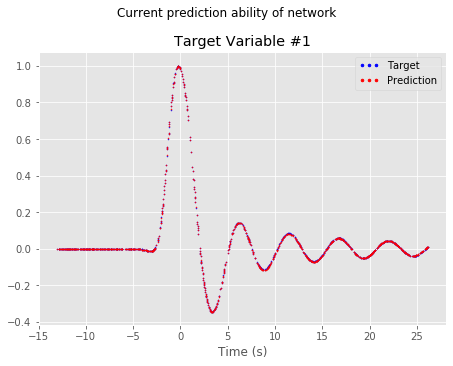

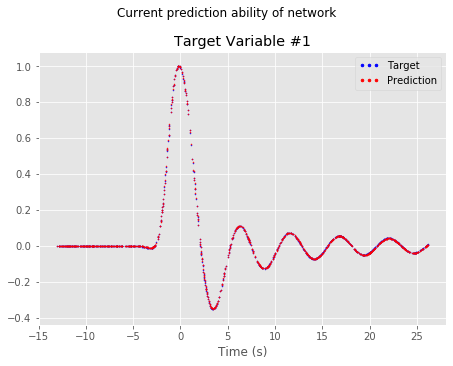

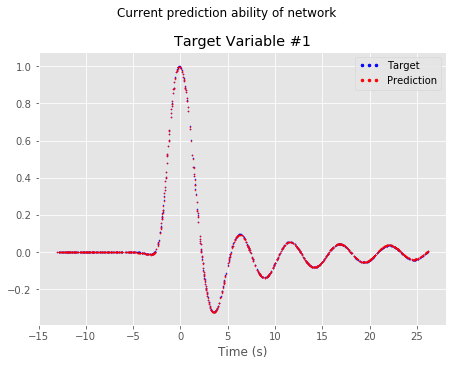

In [11]:
for param_val in param_vals_1:
    
    print('Starting loop with parameter value:', param_val)
    
    # Update investigated parameter
    eta[1] = param_val
    
    # reset randomised initialisation
    np.random.seed(np_seed)
    torch.manual_seed(torch_seed)

    # DATA GENERATION
    
    # Update model
    # Convert to the equivalent description of GMM which is what flow is forced to presume given input_type
#     E, eta = VE_params.convert_between_models(E_GKM, eta_GKM, 'GKM')
#     print('Converted!')
    
    # Generate data using updated model
#     strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)
    strain_array, stress_array = VE_datagen.calculate_int_diff_equation_initial(time_array, input_expr, E, eta, input_type, mech_model)
#     print('Calculated!')
    
    # Scale data
    strain_sf = 1/np.max(abs(strain_array))
    stress_sf = 1/np.max(abs(stress_array))
    
    if input_type == 'Strain':
        scaled_input_torch_lambda = lambda t: strain_sf*input_torch_lambda(t/time_sf)
        scaled_target_array = stress_array*stress_sf
    elif input_type == 'Stress':
        scaled_input_torch_lambda = lambda t: stress_sf*input_torch_lambda(t/time_sf)
        scaled_target_array = strain_array*strain_sf
    
    # Add noise to value at each time point
    noisy_target_array = scaled_target_array + noise_level * np.std(scaled_target_array) * np.random.standard_normal(scaled_target_array.shape)

    # randomly sample
    reordered_row_indices = np.random.permutation(scaled_time_array.size)
    reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
    reduced_target_array = scaled_target_array[reordered_row_indices, :][:number_of_samples]

    # DEEPMOD PREPARATION
    # convert to tensors
    time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
    target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)
    
    # load redefined torch expression for scaled input
    library_config['input_expr'] = scaled_input_torch_lambda

    
    # DEEPMOD
    # record start time for later transfer of tensorboard files to correct folders
    # start time is always in GMT, regardless of system clock it seems....
    now = datetime.now()
    dt_string = now.strftime('%d/%m/%Y %H:%M:%S')

    # run DeepMoD
    print('Running DeepMoD')
    model = run_deepmod(time_tensor, target_tensor, library_config, network_config, optim_config, report_config)
    network = model.network
    lstsq_guess_list = model.fit.initial_guess
    sparse_coeff_vector_list_list = model.fit.coeff_vector_history
    sparsity_mask_list_list = model.fit.sparsity_mask_history
    print('Saving results')


    # ORGANISING RESULTS
    # Calculate unscaled expected coeffs.
    unscaled_expected_coeffs = VE_params.coeffs_from_model_params(E, eta, mech_model)

    # Scale true coeffs to ones we expect to be found after scaling.
    # Convert list of expected coeffs to array for saving
    scaled_expected_coeffs = VE_params.scaled_coeffs_from_true(unscaled_expected_coeffs, time_sf, strain_sf, stress_sf)
    target_coeffs_array = np.array(scaled_expected_coeffs).reshape(-1,1)
    
    # recalculate prediction from trained network and convert to array for saving
    prediction_array = np.array(network(time_tensor).detach().cpu())
    
    # convert pre-thresholding coeffs data to arrays for saving
    pre_thresh_coeffs_array = np.array(sparse_coeff_vector_list_list[0][0].detach().cpu())
#     pre_thresh_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[0][0].detach().cpu())

    # convert final coeffs data to arrays for saving
    final_coeffs_array = np.array(sparse_coeff_vector_list_list[-1][0].detach().cpu())
#     final_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[-1][0].detach().cpu())
    sparsity_mask_array = np.array(sparsity_mask_list_list[-1][0].cpu()).reshape(-1,1)

    # group like data vectors together for saving
    dg_series_data = np.concatenate((time_array, strain_array, stress_array), axis=1)
    NN_series_data = np.concatenate((reduced_time_array, reduced_target_array, prediction_array), axis=1)
#     pre_thresh_coeffs_data = np.concatenate((pre_thresh_coeffs_array, pre_thresh_scaled_coeffs_array), axis=1)
#     final_coeffs_data = np.concatenate((final_coeffs_array, final_scaled_coeffs_array, sparsity_mask_array), axis=1)
    pre_thresh_coeffs_data = pre_thresh_coeffs_array
    final_coeffs_data = np.concatenate((final_coeffs_array, sparsity_mask_array), axis=1)
    
    # remove input library from dictionary
    library_config.pop('input_theta')
    
    # Gather miscellaneous information into lists for saving
    dg_info_list = ['Model: '+mech_model, f'E: {E}', f'eta: {eta}', 'Input: '+input_type, 'Desc: '+func_desc, f'omega: {omega}', f'Amp: {Amp}']
    treatment_info_list = [f'noise_factor: {noise_level}', f'time_sf: {time_sf}', f'strain_sf: {strain_sf}', f'stress_sf: {stress_sf}']
    config_dict_list = [f'optim: {optim_config}', f'network: {network_config}', f'library: {library_config}']
    misc_list = ['date_stamp: '+dt_string, f'NumPy_seed: {np_seed}', f'Torch_seed: {torch_seed}']
#     GKM_list = [f'E_GKM: {E_GKM}', f'eta_GKM: {eta_GKM}']

    # SAVING RESULTS
    # collect parameters to name folder for saving
    second_subfolder = 'param_' + str(param_val).replace('.', '-')
#     third_subfolder = 'noise_' + str(noise_level).replace('.', '-')
#     fourth_subfolder = 'seed_' + str(seed_value)
    foldername = parent_folder + '/' + first_subfolder + '/' + second_subfolder# + '/' + third_subfolder + '/' + fourth_subfolder

    # make folder
    if not os.path.isdir(foldername):
        os.makedirs(foldername)

    # save all array data
    np.savetxt(foldername+'/DG_series_data.csv', dg_series_data, delimiter=',', header='Time, Strain, Stress')
    np.savetxt(foldername+'/NN_series_data.csv', NN_series_data, delimiter=',', header='Time, Target, Prediction')
    np.savetxt(foldername+'/expected_coeffs.csv', target_coeffs_array, delimiter=',', header='Expected_coeffs')
#     np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs')
#     np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs, Sparsity_Mask')
    np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_data, delimiter=',', header='Trained_Coeffs')
    np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Sparsity_Mask')
    
    # save all lists data
    with open(foldername+'/DG_info_list.txt', 'w') as file:
        file.writelines(f'{line}\n' for line in dg_info_list)
        
    with open(foldername+'/treatment_info_list.txt', 'w') as file:
        file.writelines(f'{line}\n' for line in treatment_info_list)
    
    with open(foldername+'/config_dict_list.txt', 'w') as file:
        file.writelines(f'{line}\n' for line in config_dict_list)
    
    with open(foldername+'/misc_list.txt', 'w') as file:
        file.writelines(f'{line}\n' for line in misc_list)
        
#     with open(foldername+'/GKM_list.txt', 'w') as file:
#         file.writelines(f'{line}\n' for line in GKM_list)